In [15]:
# Импорты
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as T
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [3]:
# Путь к распакованному датасету
dataset_root = "Forest/Forest Segmented/Forest Segmented"

In [5]:
# Dataset
# -----------------------------
class ForestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.images = sorted([f for f in os.listdir(self.image_dir) if f.endswith(".jpg")])
        self.masks = sorted([f for f in os.listdir(self.mask_dir) if f.endswith(".jpg")])
        assert len(self.images) == len(self.masks), "Количество изображений и масок должно совпадать"
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_dir, self.masks[idx]), cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype("float32")  # обязательно float32

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]  # float32, [3,H,W]
        else:
            image = torch.from_numpy(image.transpose(2,0,1)).float()

        mask = torch.from_numpy(mask).float().unsqueeze(0)  # [1,H,W]
        return image, mask


In [6]:
# -----------------------------
# Аугментации
# -----------------------------
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),   # нормализация изображения
    ToTensorV2()     # применяем только к image
])

In [7]:

# -----------------------------
# Dataset и DataLoader
# -----------------------------
dataset = ForestDataset(dataset_root, transform=train_transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

In [8]:
# Проверка
img, mask = dataset[0]
print("Image:", img.shape, img.dtype)
print("Mask:", mask.shape, mask.dtype)

Image: torch.Size([3, 256, 256]) torch.float32
Mask: torch.Size([1, 256, 256]) torch.float32


In [9]:

# -----------------------------
# Модель
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)
model.to(device)

cuda


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [10]:
# -----------------------------
# Loss и optimizer
# -----------------------------
loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:

# -----------------------------
# Метрики
# -----------------------------
def dice_coef(preds, targets, threshold=0.5, eps=1e-6):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets).sum(dim=(1,2,3)) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

In [ ]:

# # -----------------------------
# # Обучение
# # -----------------------------
# epochs = 10

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     total_dice = 0
#     total_iou = 0

#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = loss_fn(outputs, masks)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         total_dice += dice_coef(outputs, masks)
#         total_iou += iou_score(outputs, masks)

#     n_batches = len(train_loader)
#     print(f"Epoch [{epoch+1}/{epochs}] | "
#           f"Loss: {total_loss/n_batches:.4f} | "
#           f"Dice: {total_dice/n_batches:.4f} | "
#           f"IoU: {total_iou/n_batches:.4f}")


Epoch [1/10] | Loss: 0.2463 | Dice: 0.6839 | IoU: 0.5983
Epoch [2/10] | Loss: 0.1964 | Dice: 0.7012 | IoU: 0.6205
Epoch [3/10] | Loss: 0.1861 | Dice: 0.7077 | IoU: 0.6269
Epoch [4/10] | Loss: 0.1747 | Dice: 0.7126 | IoU: 0.6344
Epoch [5/10] | Loss: 0.1716 | Dice: 0.7170 | IoU: 0.6387
Epoch [6/10] | Loss: 0.1616 | Dice: 0.7256 | IoU: 0.6487
Epoch [7/10] | Loss: 0.1582 | Dice: 0.7321 | IoU: 0.6559
Epoch [8/10] | Loss: 0.1526 | Dice: 0.7414 | IoU: 0.6643
Epoch [9/10] | Loss: 0.1516 | Dice: 0.7382 | IoU: 0.6626
Epoch [10/10] | Loss: 0.1504 | Dice: 0.7422 | IoU: 0.6673


In [ ]:
# # Путь для сохранения
# save_path = "unet_forest.pth"

# # Сохраняем только state_dict (веса)
# torch.save(model.state_dict(), save_path)
# print(f"Model saved to {save_path}")


Model saved to unet_forest.pth


In [ ]:
# # Путь для сохранения
# full_model_path = "unet_forest_full.pth"

# # Сохраняем полностью модель (архитектура + веса)
# torch.save(model, full_model_path)
# print(f"Full model saved to {full_model_path}")
# print(f"Модель сохранена по пути: {full_model_path}")

Full model saved to unet_forest_full.pth


In [12]:
# Создаём такую же модель
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,  # загружаем свои веса
    in_channels=3,
    classes=1
)
model.to(device)

# Загружаем сохранённые веса
weights_path = "unet_forest_weights1.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))
print("Weights loaded successfully")


Weights loaded successfully


/tmp/ipykernel_4351/1876101309.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


In [13]:
loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # пониженный LR для дообучения


In [14]:
def dice_coef(preds, targets, threshold=0.5, eps=1e-6):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets).sum(dim=(1,2,3)) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [72]:

fine_tune_epochs = 1

for epoch in range(fine_tune_epochs):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    all_targets = []
    all_preds = []

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coef(outputs, masks)
        total_iou += iou_score(outputs, masks)

        # Данные для AP / PR / confusion
        preds_prob = torch.sigmoid(outputs).detach().cpu().numpy().ravel()
        targets_flat = masks.detach().cpu().numpy().ravel()
        all_preds.extend(preds_prob)
        all_targets.extend(targets_flat)

    n_batches = len(train_loader)
    avg_loss = total_loss / n_batches
    avg_dice = total_dice / n_batches
    avg_iou = total_iou / n_batches

    # AP / mAP
    all_targets_np = np.array(all_targets)
    all_preds_np = np.array(all_preds)
    ap_score = average_precision_score(all_targets_np, all_preds_np)

    # Confusion matrix
    threshold = 0.5
    preds_bin = (all_preds_np > threshold).astype(int)
    cm = confusion_matrix(all_targets_np, preds_bin)

    # Precision-Recall кривая
    precision, recall, _ = precision_recall_curve(all_targets_np, all_preds_np)

    print(f"Fine-tune Epoch [{epoch+1}/{fine_tune_epochs}] | "
          f"Loss: {avg_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | AP: {ap_score:.4f}")
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(5,5))
    plt.plot(recall, precision, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve Epoch {epoch+1}")
    plt.show()


KeyboardInterrupt: 

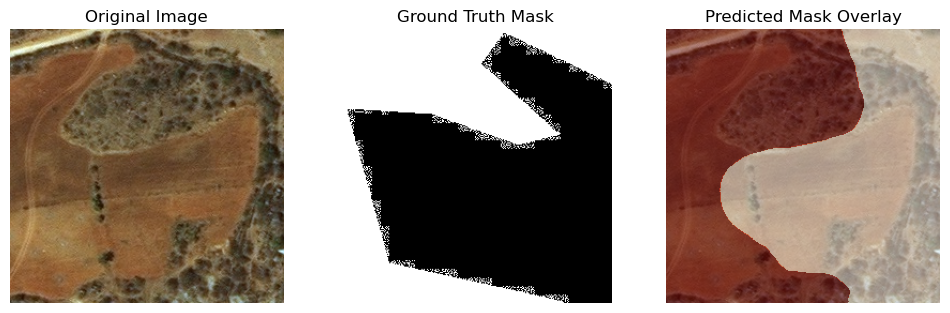

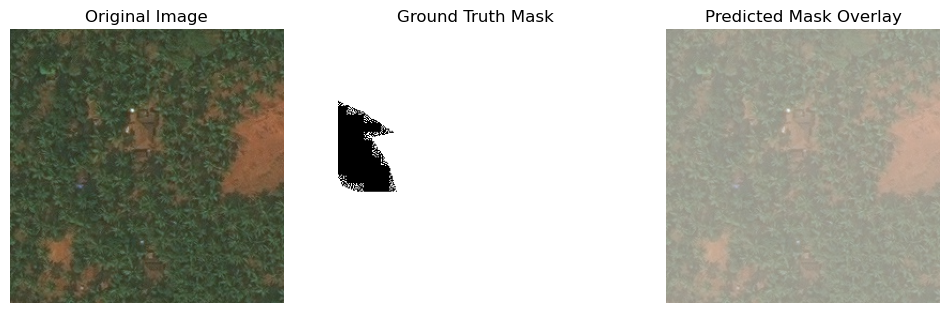

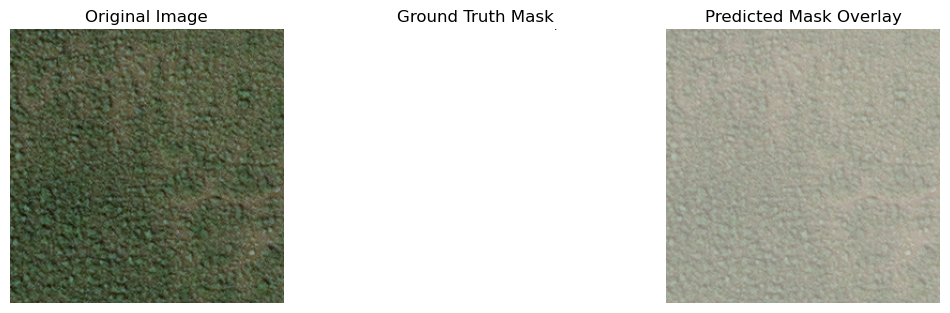

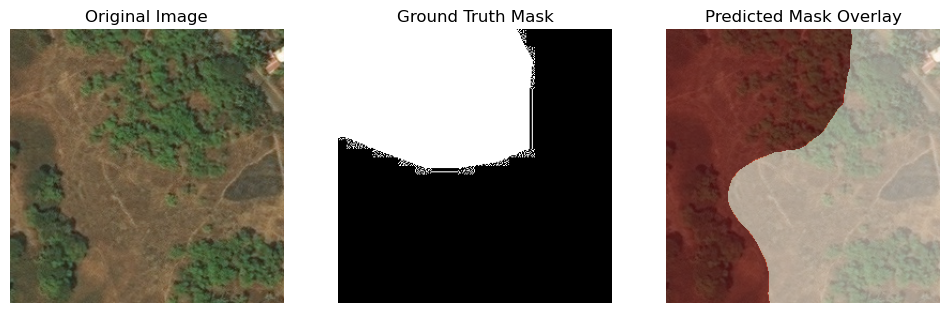

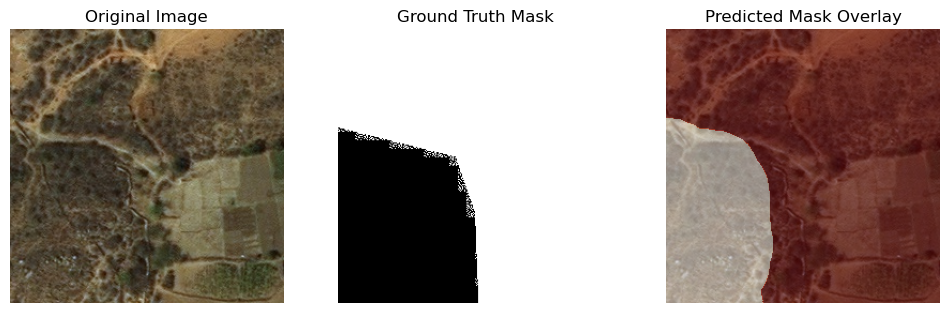

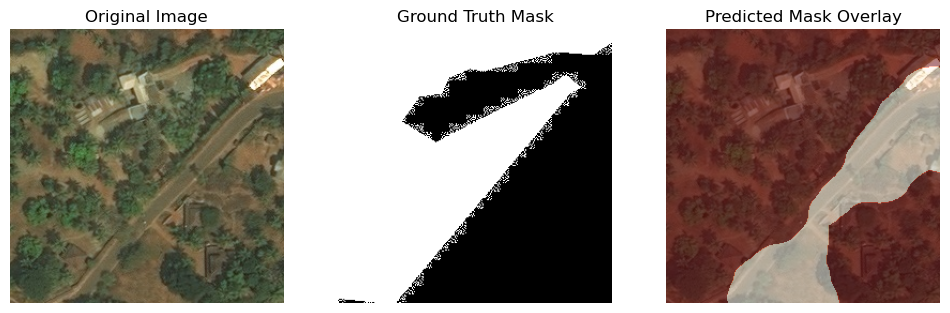

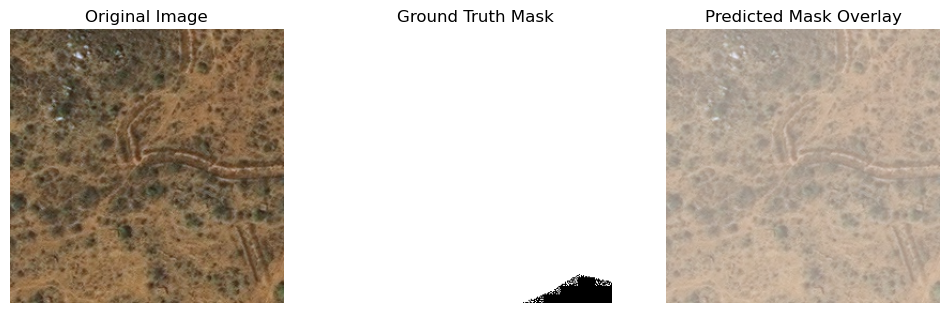

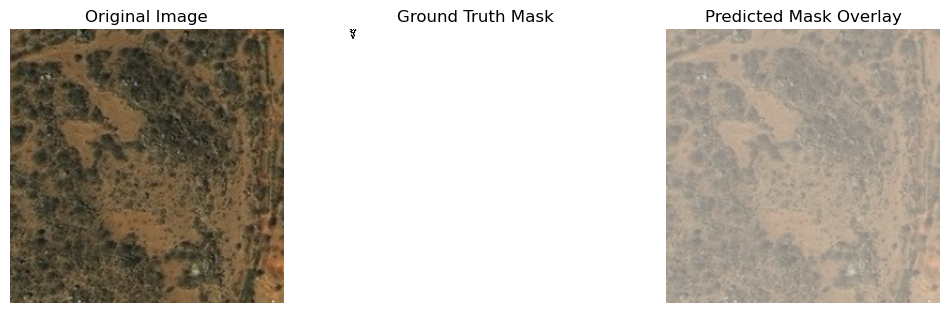

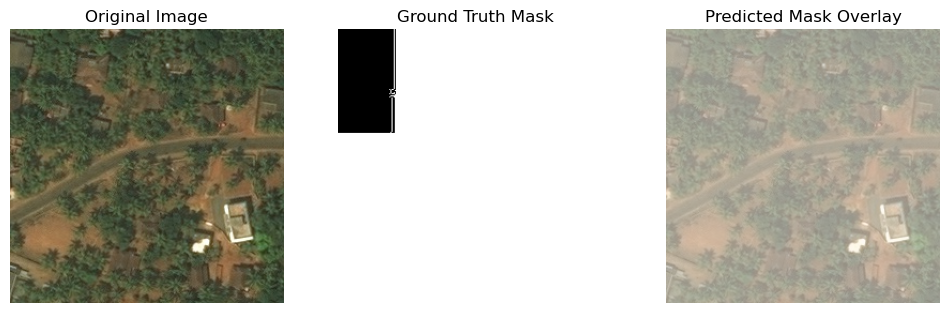

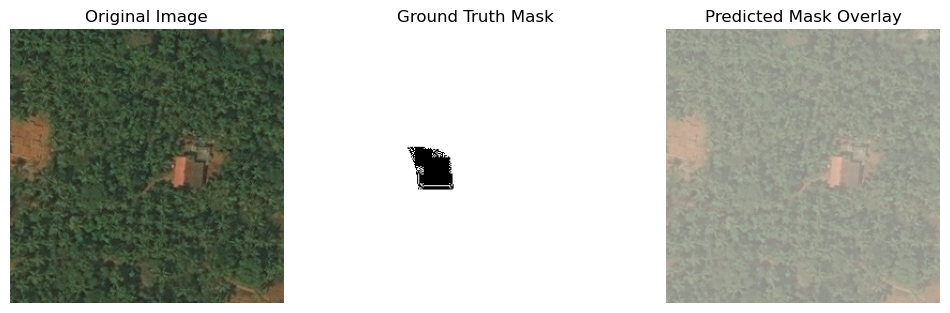

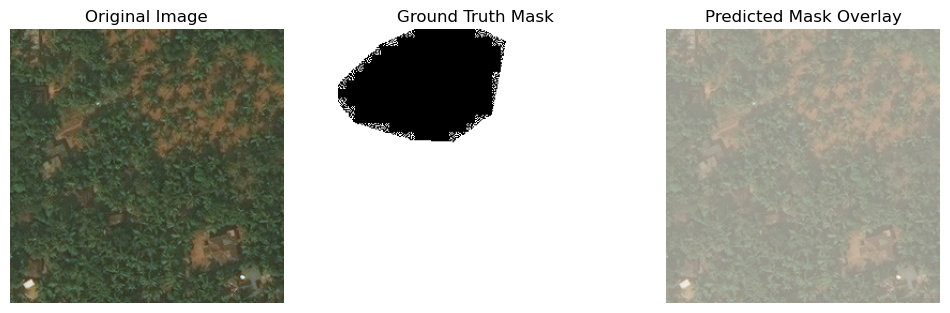

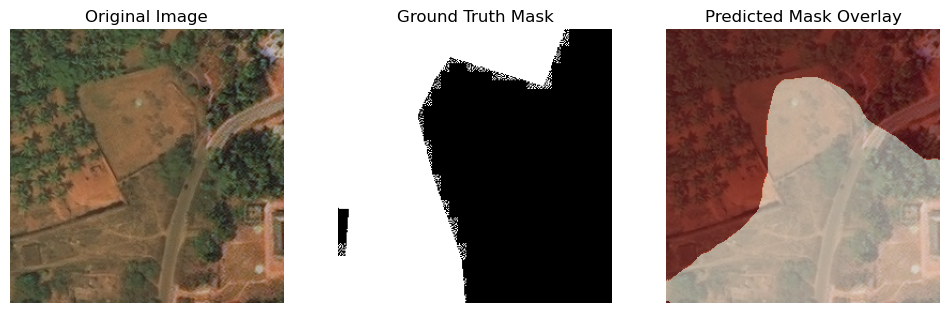

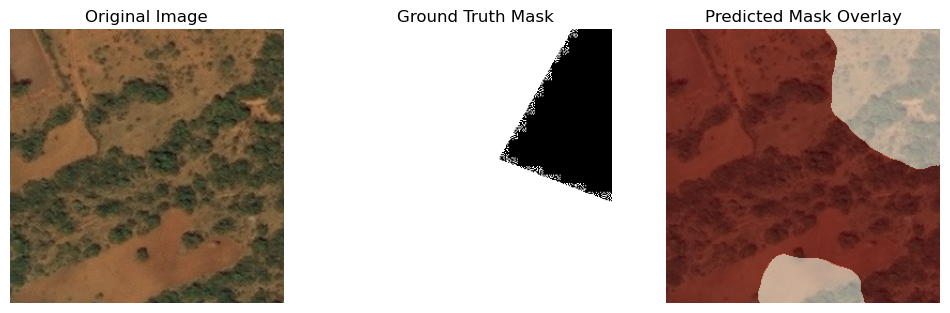

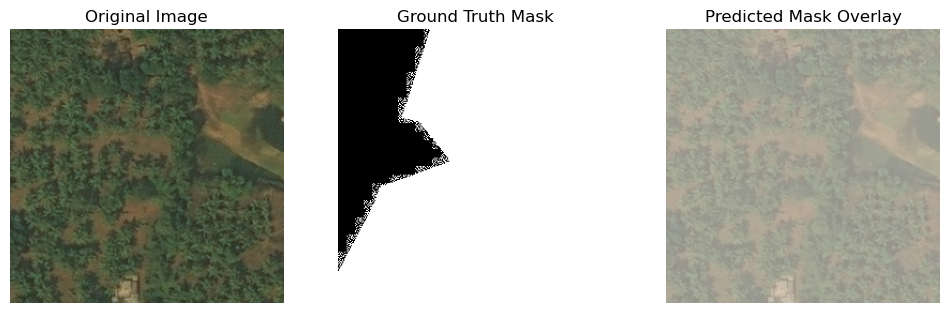

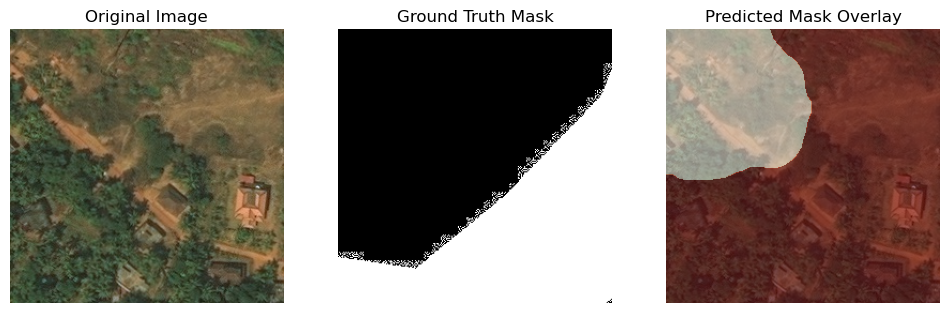

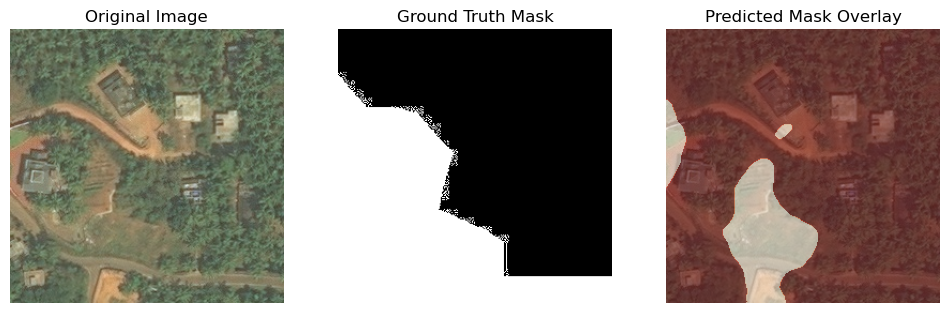

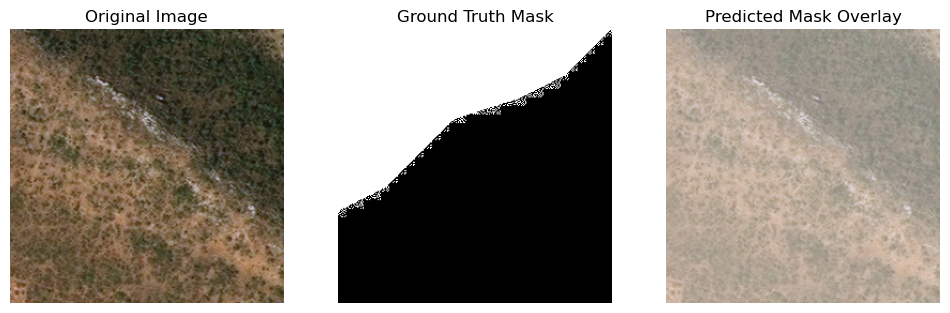

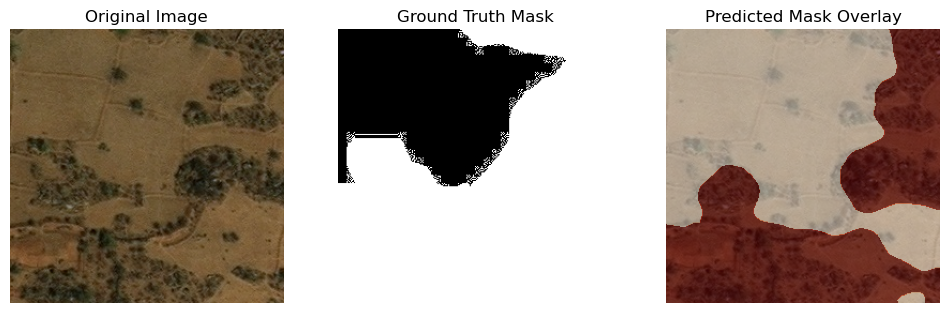

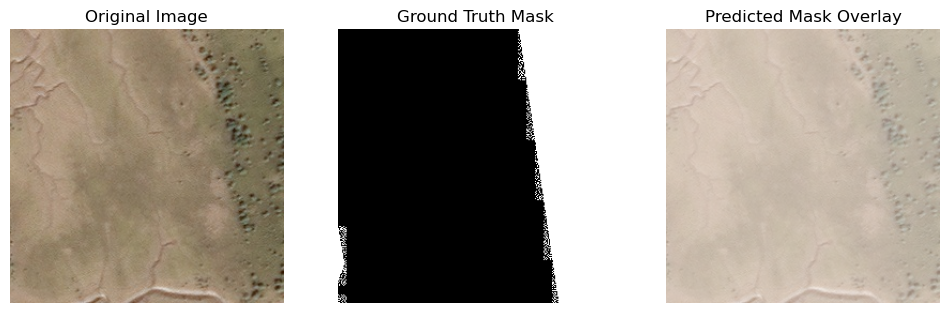

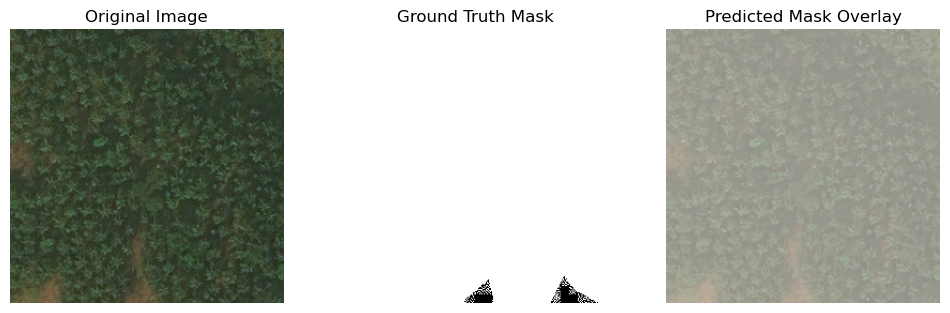

In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Функция для де-нормализации изображения ---
def denormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    img_tensor: torch.Tensor [C,H,W] с нормализацией
    Возвращает np.array [H,W,C] с пикселями в диапазоне [0,1]
    """
    img = img_tensor.clone().cpu().numpy()
    for i in range(3):
        img[i] = img[i]*std[i] + mean[i]
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))  # [C,H,W] -> [H,W,C]
    return img

# --- Переключаем модель в eval ---
model.eval()

# --- Случайные 20 изображений для примера ---
import random
num_samples = 20
indices = random.sample(range(len(dataset)), num_samples)

for idx in indices:
    # Берем изображение и маску
    image, mask = dataset[idx]
    img_np = denormalize(image)                 # де-нормализованное изображение
    true_mask = mask.squeeze(0).numpy()         # [1,H,W] -> [H,W]

    # Подготовка для модели
    input_tensor = image.unsqueeze(0).to(device)  # [1,C,H,W]

    # Предсказание
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output).squeeze(0).squeeze(0).cpu().numpy()
        pred_mask_bin = (pred_mask > 0.5).astype(np.float32)

    # --- Визуализация ---
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img_np)
    plt.imshow(pred_mask_bin, cmap='Reds', alpha=0.5)
    plt.title("Predicted Mask Overlay")
    plt.axis("off")

    plt.show()
